In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import time
import copy
import collections
import scipy as sp
import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.reload_library()
plt.style.use(['science'])

In [3]:
import ro.params as ro_params
from ro.utils.cb import get_path

### Functions

In [4]:
def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

In [5]:
def get_results(result_dir):
    """ Gets results for capital budgeting.  """
    # get files
    files = os.listdir(result_dir)
    files = list(filter(lambda x: 'results_' in x, files))
    files = list(map(lambda x: result_dir + x, files))

    # load results for all files
    results = {}
    for n_items in cfg.n_items:
        results[n_items] = []

    for file in files:
        with open(file, 'rb') as p:
            file_res = pkl.load(p)
            n_items = len(file_res['ml']['x'])
            results[n_items].append(file_res)
            
    return results

In [6]:
def get_item_results(results, n_items, k_vals):
    """ Gets results for n_items and a list of K (for K-adapt baseline). """
    agg_results = {}

    # get results for ML algorithm
    obj_ml = list(map(lambda x: x['obj_ml'], results[n_items]))
    time_ml = list(map(lambda x: x['time_ml'], results[n_items]))
    n_iters_ml = list(map(lambda x: x['ml']['opt_stats']['n_iterations'], results[n_items]))
    n_nans = list(map(lambda x: np.isnan(x['time_ml']), results[n_items]))
    
    agg_results['obj_ml'] = obj_ml
    agg_results['time_ml'] = time_ml
    agg_results['ml_n_iters'] = n_iters_ml
    agg_results['ml_n_sols'] = len(n_nans) - np.sum(n_nans)
    
    # get times/gaps for K-adaptibility
    for k in k_vals:
        
        res_k = list(map(lambda x: x['k_adapt_results'][k], results[n_items]))
        
        # results at ML termination time
        obj_k_at_ml = list(map(lambda x: x['obj_k_adapt_at_ml_time'][k], results[n_items]))
        gap_k_at_ml = list(map(lambda x: x['gaps_at_ml_time'][k], results[n_items]))
        # n_nans_k_at_ml = list(map(lambda x: np.isnan(x['gaps_at_ml_time'][k]), results[n_items]))
        n_sols_k_at_ml = np.sum(list(map(lambda x: x['sol_at_ml_time'], res_k)))
        

        # results at 3 hour time limit
        gap_k = list(map(lambda x: x['gaps'][k], results[n_items]))
        obj_k = list(map(lambda x: x['obj_kadapt'][k], results[n_items]))
        time_k = list(map(lambda x: x['time'], res_k))
        n_nans_k = list(map(lambda x: np.isnan(x['time']), res_k))

        # add to dataframe
        agg_results[f'obj_{k}'] = obj_k
        agg_results[f'gap_{k}'] = gap_k
        agg_results[f'time_{k}'] = time_k
        agg_results[f'n_sols_{k}'] = len(n_nans_k) - np.sum(n_nans_k)
        
        agg_results[f'obj_at_ml_time_{k}'] = obj_k_at_ml
        agg_results[f'gap_at_ml_time_{k}'] = gap_k_at_ml
        agg_results[f'n_sols_at_ml_time_{k}'] = n_sols_k_at_ml # len(n_nans_k_at_ml) - np.sum(n_nans_k_at_ml)
    
    return agg_results

In [7]:
def get_best_known_solution(n_item_res, k_vals, res_at_ml_time):
    """ Gets best known solution between all methods.  """
    # get best known solution
    best_known_sols = []
    n_items = []
    for i in range(len(n_item_res['obj_ml'])):
        best_obj = n_item_res['obj_ml'][i]
        
        for k in k_vals:
            
            # get objective
            if res_at_ml_time:
                obj_k = n_item_res[f'obj_at_ml_time_{k}'][i]
            else:
                 obj_k = n_item_res[f'obj_{k}'][i]
                
            # update objective
            if obj_k < best_obj:
                
                best_obj = obj_k
                
        best_known_sols.append(best_obj)
        
    best_known_sol = np.array(best_known_sols)
    
    return best_known_sol

In [8]:
def get_agg_df(cfg, results, k_vals, res_at_ml_time=False, use_g_mean=False, use_median=True, tol=1e-4):
    """ todo """
    n_items = cfg.n_items
    
    # get columns for table
    cols = []
    cols.append(f"obj_ml")
    for k in k_vals:
        cols.append(f"obj_{k}")
    
    # columns for gap to best known
    cols.append(f"mre_ml")
    for k in k_vals:
        cols.append(f"mre_{k}")
        
    # columns for gap to best known at ML time
    cols.append(f"mre_at_ml_time_ml")
    for k in k_vals:
        cols.append(f"mre_at_ml_time_{k}")
        
    # cols for 
    cols.append(f"n_best_sol_ml")
    for k in k_vals:
        cols.append(f"n_best_sol_{k}")
    
    # columns for gaps
    for k in k_vals:
        cols.append(f"gap_{k}")
        cols.append(f"gap_at_ml_time_{k}")
        
    # columns for num improved
    for k in k_vals:
        cols.append(f"better_{k}")

    # columns for times
    cols.append("time_ml")
    for k in k_vals:
        cols.append(f"time_{k}")
        
    # columns for snumber of iterations
    cols.append('ml_n_iters')
    
    # columns for number of successful runs
    cols.append("ml_n_sols")
    for k in k_vals:
        cols.append(f"n_sols_{k}")
        cols.append(f"n_sols_at_ml_time_{k}")
        
    
    # initialize dataframe
    df = pd.DataFrame(columns=cols, index=n_items)
    
    # get aggregate results for each number of items
    for n_item in n_items:
        
        # get results at ml time
        n_item_res = get_item_results(results, n_item, k_vals)
        
        # gep to best known
        best_known_sol = get_best_known_solution(n_item_res, k_vals, res_at_ml_time=False)
        best_known_sol_at_ml_time = get_best_known_solution(n_item_res, k_vals, res_at_ml_time=True)

        # mre for ML
        mre_ml = 100 * (best_known_sol - n_item_res['obj_ml']) / best_known_sol
        mre_ml_at_ml_time =  100 * (best_known_sol_at_ml_time - n_item_res['obj_ml']) / best_known_sol_at_ml_time
        
        if use_median:
            df["mre_ml"][n_item] = np.nanmedian(mre_ml)
            df["mre_at_ml_time_ml"][n_item] = np.nanmedian(mre_ml_at_ml_time)       
        else:
            df["mre_ml"][n_item] = np.nanmean(mre_ml)
            df["mre_at_ml_time_ml"][n_item] = np.nanmean(mre_ml_at_ml_time)
        
        df['n_best_sol_ml'][n_item] = np.sum(mre_ml < 1e-8)  / len(mre_ml)
        
        for k in k_vals:
            
            # gap to best-known            
            mre_k = 100 * (best_known_sol - n_item_res[f'obj_{k}']) / best_known_sol
            mre_k_at_ml_time = 100 * (best_known_sol_at_ml_time - n_item_res[f'obj_at_ml_time_{k}']) / best_known_sol_at_ml_time
            
            if use_median:
                df[f"mre_{k}"][n_item] = np.nanmedian(mre_k)
                df[f"mre_at_ml_time_{k}"][n_item] = np.nanmedian(mre_k_at_ml_time)
            else:
                df[f"mre_{k}"][n_item] = np.nanmean(mre_k)
                df[f"mre_at_ml_time_{k}"][n_item] = np.nanmean(mre_k_at_ml_time)
            
            # other metrics
            df[f'n_best_sol_{k}'][n_item] = np.sum(mre_k < 1e-8) / len(mre_k)
            
            df[f"obj_{k}"][n_item] = np.nanmean(n_item_res[f'obj_{k}'])
            df[f"gap_at_ml_time_{k}"][n_item] = np.nanmean(n_item_res[f'gap_at_ml_time_{k}'])
            df[f"gap_{k}"][n_item] = np.nanmean(n_item_res[f'gap_{k}'])
            df[f'n_sols_{k}'][n_item] =  n_item_res[f'n_sols_{k}']
            df[f'n_sols_at_ml_time_{k}'][n_item] =  n_item_res[f'n_sols_at_ml_time_{k}']
                
            if not use_g_mean:
                df[f"time_{k}"][n_item] = np.nanmean(n_item_res[f'time_{k}'])
            else:
                df[f"time_{k}"][n_item] = geo_mean(n_item_res[f'time_{k}'])
                
            # number of low gaps + number of better solutions
            n_total = len(n_item_res[f'time_ml'])

            n_better = np.sum(np.array(n_item_res[f'gap_{k}']) < -tol)
            n_better += np.sum((list(map(lambda x: np.isnan(x), n_item_res[f'gap_{k}']))))
            pct_better = 100 * n_better / n_total
            
            df[f"better_{k}"][n_item] = pct_better
                        
        # ml times, num solutions, and number of iterations
        df["obj_ml"][n_item] = np.nanmean(n_item_res['obj_ml'])
        df["time_ml"][n_item] = np.nanmean(n_item_res['time_ml'])
        df["ml_n_sols"][n_item] = n_item_res['ml_n_sols']
        
        if not use_g_mean:
            df["time_ml"][n_item] = np.nanmean(n_item_res['time_ml'])
            df["ml_n_iters"][n_item] = np.nanmean(n_item_res['ml_n_iters'])            
        else:
            df["time_ml"][n_item] = geo_mean(n_item_res['time_ml'])
            df["ml_n_iters"][n_item] = geo_mean(n_item_res['ml_n_iters'])
    
    return df

In [9]:
def latex_combined_results(df_, at_ml_time=False):
    """ Generate Latex table for combined results.  """

    df = df_.copy()

    if at_ml_time:
        df.rename(columns={
            'mre_at_ml_time_ml' : '\\method{}',
            'mre_at_ml_time_2' : '$k=2$',
            'mre_at_ml_time_5' : '$k=5$',
            'mre_at_ml_time_10' : '$k=10$',
            'time_ml' : '\\method{}\ \ ',
            'time_2' : '$k=2$\ \ ',
            'time_5' : '$k=5$\ \ ',
            'time_10' : '$k=10$\ \ ',
           }, inplace=True)
        
    else:
        df.rename(columns={
            'mre_ml' : '\\method{}',
            'mre_2' : '$k=2$',
            'mre_5' : '$k=5$',
            'mre_10' : '$k=10$',
            'time_ml' : '\\method{}\ \ ',
            'time_2' : '$k=2$\ \ ',
            'time_5' : '$k=5$\ \ ',
            'time_10' : '$k=10$\ \ ',
           }, inplace=True)

    
    #df = df.style.format(thousands=',')#, precision=4)    
    df = df.style.format(thousands=',', formatter = 
        {'\\method{}'       : '{:.3f}'.format,
         '$k=2$'            : '{:.3f}'.format,
         '$k=5$'            : '{:.3f}'.format,
         '$k=10$'           : '{:.3f}'.format,
         '\\method{}\ \ '   : '{:.0f}'.format,
         '$k=2$\ \ '        : '{:.0f}'.format,
         '$k=5$\ \ '        : '{:.0f}'.format,
         '$k=10$\ \ '       : '{:.0f}'.format, 
        })
            

    df = df.highlight_min(subset=['\\method{}', '$k=2$', '$k=5$', '$k=10$'], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['\\method{}\ \ ', '$k=2$\ \ ', '$k=5$\ \ ', '$k=10$\ \ '], props='textbf:--rwrap;', axis=1)
    
    end_str = '}\n\\caption{Combined results for capital budgeting instances.  All times in seconds.}\n'
    end_str += '\\label{tab:cb_results}\n'
    end_str += '\\end{table*}' 

    latex_str = df.to_latex(column_format='l|rrrr|rrrr').replace('_','\_').replace('nan', '-').replace('#', '\#')

    latex_str2 = (latex_str.splitlines())
    latex_str2.insert(1, '\\toprule')
    
    latex_str2.insert(2, '\# items & \multicolumn{4}{c|}{Median RE} & \multicolumn{4}{c}{Times (seconds)}  \\\\')
    
    latex_str2.insert(4, '\\midrule')
    latex_str2.insert(-1, '\\bottomrule')
    latex_str2.insert(0, '\\begin{table*}[h]\\centering\\resizebox{1.0\\textwidth}{!}{')
    latex_str2[-1] += end_str 

    print("\n".join(latex_str2))
    print()

## Data Directory

In [10]:
data_dir = '../data/'

In [11]:
problem = 'cb'
cfg = getattr(ro_params, problem)

In [12]:
k_vals = [2, 5, 10]

In [13]:
fp_inst = get_path(data_dir, cfg, "inst")
fp_data = get_path(data_dir, cfg, "ml_data")
fp_nn = get_path(data_dir, cfg, "set_encoder")
fp_nn_res = get_path(data_dir, cfg, "set_encoder_tr_res")

In [14]:
result_dir = data_dir + problem + '/eval_results/'

In [15]:
results = get_results(result_dir)

# Main paper: Tables

In [16]:
df = get_agg_df(cfg, results, k_vals, res_at_ml_time=False)

In [17]:
cols = [
        'mre_at_ml_time_ml', 'mre_at_ml_time_2', 'mre_at_ml_time_5', 'mre_at_ml_time_10',
        'time_ml', 'time_2', 'time_5', 'time_10', 
       ]

df_at_ml_time = df[cols]

In [18]:
cols = ['mre_ml', 'mre_2', 'mre_5', 'mre_10', 
        'time_ml', 'time_2', 'time_5', 'time_10']

df = df[cols]

In [19]:
latex_combined_results(df)

\begin{table*}[h]\centering\resizebox{1.0\textwidth}{!}{
\begin{tabular}{l|rrrr|rrrr}
\toprule
\# items & \multicolumn{4}{c|}{Median RE} & \multicolumn{4}{c}{Times (seconds)}  \\
 & \method{} & $k=2$ & $k=5$ & $k=10$ & \method{}\ \  & $k=2$\ \  & $k=5$\ \  & $k=10$\ \  \\
\midrule
10 & 1.105 & 1.140 & \textbf{0.000} & \textbf{0.000} & 59 & \textbf{20} & 9561 & 10800 \\
20 & \textbf{0.000} & 0.196 & 0.112 & 0.064 & \textbf{324} & 8702 & 10800 & 10800 \\
30 & 0.109 & \textbf{0.020} & 0.073 & 0.032 & \textbf{602} & 10801 & 10800 & 10800 \\
40 & \textbf{0.009} & 0.074 & 0.011 & 0.019 & \textbf{739} & 10806 & 10801 & 10801 \\
50 & \textbf{0.001} & 0.033 & 0.039 & 0.020 & \textbf{1032} & 10807 & 10804 & 10801 \\
\bottomrule
\end{tabular}}
\caption{Combined results for capital budgeting instances.  All times in seconds.}
\label{tab:cb_results}
\end{table*}



In [20]:
latex_combined_results(df_at_ml_time, at_ml_time=True)

\begin{table*}[h]\centering\resizebox{1.0\textwidth}{!}{
\begin{tabular}{l|rrrr|rrrr}
\toprule
\# items & \multicolumn{4}{c|}{Median RE} & \multicolumn{4}{c}{Times (seconds)}  \\
 & \method{} & $k=2$ & $k=5$ & $k=10$ & \method{}\ \  & $k=2$\ \  & $k=5$\ \  & $k=10$\ \  \\
\midrule
10 & 0.809 & 1.559 & \textbf{0.267} & 0.359 & 59 & \textbf{20} & 9561 & 10800 \\
20 & \textbf{0.011} & 0.240 & 0.098 & 0.084 & \textbf{324} & 8702 & 10800 & 10800 \\
30 & 0.102 & 0.067 & 0.093 & \textbf{0.029} & \textbf{602} & 10801 & 10800 & 10800 \\
40 & \textbf{0.013} & 0.079 & 0.058 & 0.019 & \textbf{739} & 10806 & 10801 & 10801 \\
50 & \textbf{0.002} & 0.035 & 0.006 & 0.008 & \textbf{1032} & 10807 & 10804 & 10801 \\
\bottomrule
\end{tabular}}
\caption{Combined results for capital budgeting instances.  All times in seconds.}
\label{tab:cb_results}
\end{table*}



# Appendix: Boxplot

In [21]:
def compute_mre(best_known_sol, algo_sol):
    return 100 * np.abs(best_known_sol - algo_sol) / np.abs(best_known_sol)

In [22]:
def get_mre_vals(results, cfg, k_vals):
    
    mres = {'ml' : [], 2 : [], 5 : [], 10 : [] }
    
    for n_items in cfg.n_items:
        # get results best sol
        n_item_res = get_item_results(results, n_items, k_vals)
        best_known_sol = get_best_known_solution(n_item_res, k_vals, res_at_ml_time=False)
        
        # compute all mre values
        mres['ml'].append(compute_mre(best_known_sol, n_item_res['obj_ml']))
        for k in k_vals:
            mres[k].append(compute_mre(best_known_sol, n_item_res[f'obj_{k}']))
            
    return mres

In [23]:
def create_boxplot(data_groups, labels, fontsize=16):
    
    width       = 1/len(labels)
    xlocations  = [ x*((1+ len(data_groups))*width) for x in range(len(data_groups[0])) ]

    ymin        = min ( [ val  for dg in data_groups  for data in dg for val in data ] )
    ymax        = max ( [ val  for dg in data_groups  for data in dg for val in data ])
    
    colors = ['#ECEE81', '#8DDFCB', '#82A0D8', '#EDB7ED']
    
    with plt.style.context(['science', 'nature', 'bright']):

        fig, ax = plt.subplots(figsize=(2.8 * len(data_groups[0]),4), dpi=300)
        ax = plt.gca()

        space = len(data_groups)/2
        offset = len(data_groups)/2

        # --- Offset the positions per group:

        group_positions = []
        for num, dg in enumerate(data_groups):    
            _off = (0 - space + (0.5+num))
            group_positions.append([x+_off*(width+0.01) for x in xlocations])

        for dg, pos, c in zip(data_groups, group_positions, colors):
            boxes = ax.boxplot(dg, 
                        labels=['']*len(labels),
                        positions=pos, 
                        widths=width, 
                        boxprops=dict(facecolor=c),                    
                        patch_artist=True)

        # legends
        custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                        Line2D([0], [0], color=colors[1], lw=4),
                        Line2D([0], [0], color=colors[2], lw=4),
                        Line2D([0], [0], color=colors[3], lw=4),]
        ax.legend(custom_lines,['\\texttt{Neur2RO}', '$k=2$', '$k=5$', '$k=10$'], fontsize=fontsize)

        plt.axhline(y=0.0, color='lightgrey', linestyle='-')

        ax.set_xticks(xlocations)
        ax.set_xticklabels(labels, rotation=0)

        ax.set_ylabel('RE', fontsize=fontsize)
        ax.set_xlabel('\# Items', fontsize=fontsize)

        plt.yticks(fontsize=fontsize)  
        plt.xticks(fontsize=fontsize)   

        #plt.ylim(0,1)
        plt.show()
    

In [24]:
mres = get_mre_vals(results, cfg, k_vals)

In [25]:
data_groups = [mres['ml'], mres[2], mres[5], mres[10]]
labels = cfg.n_items

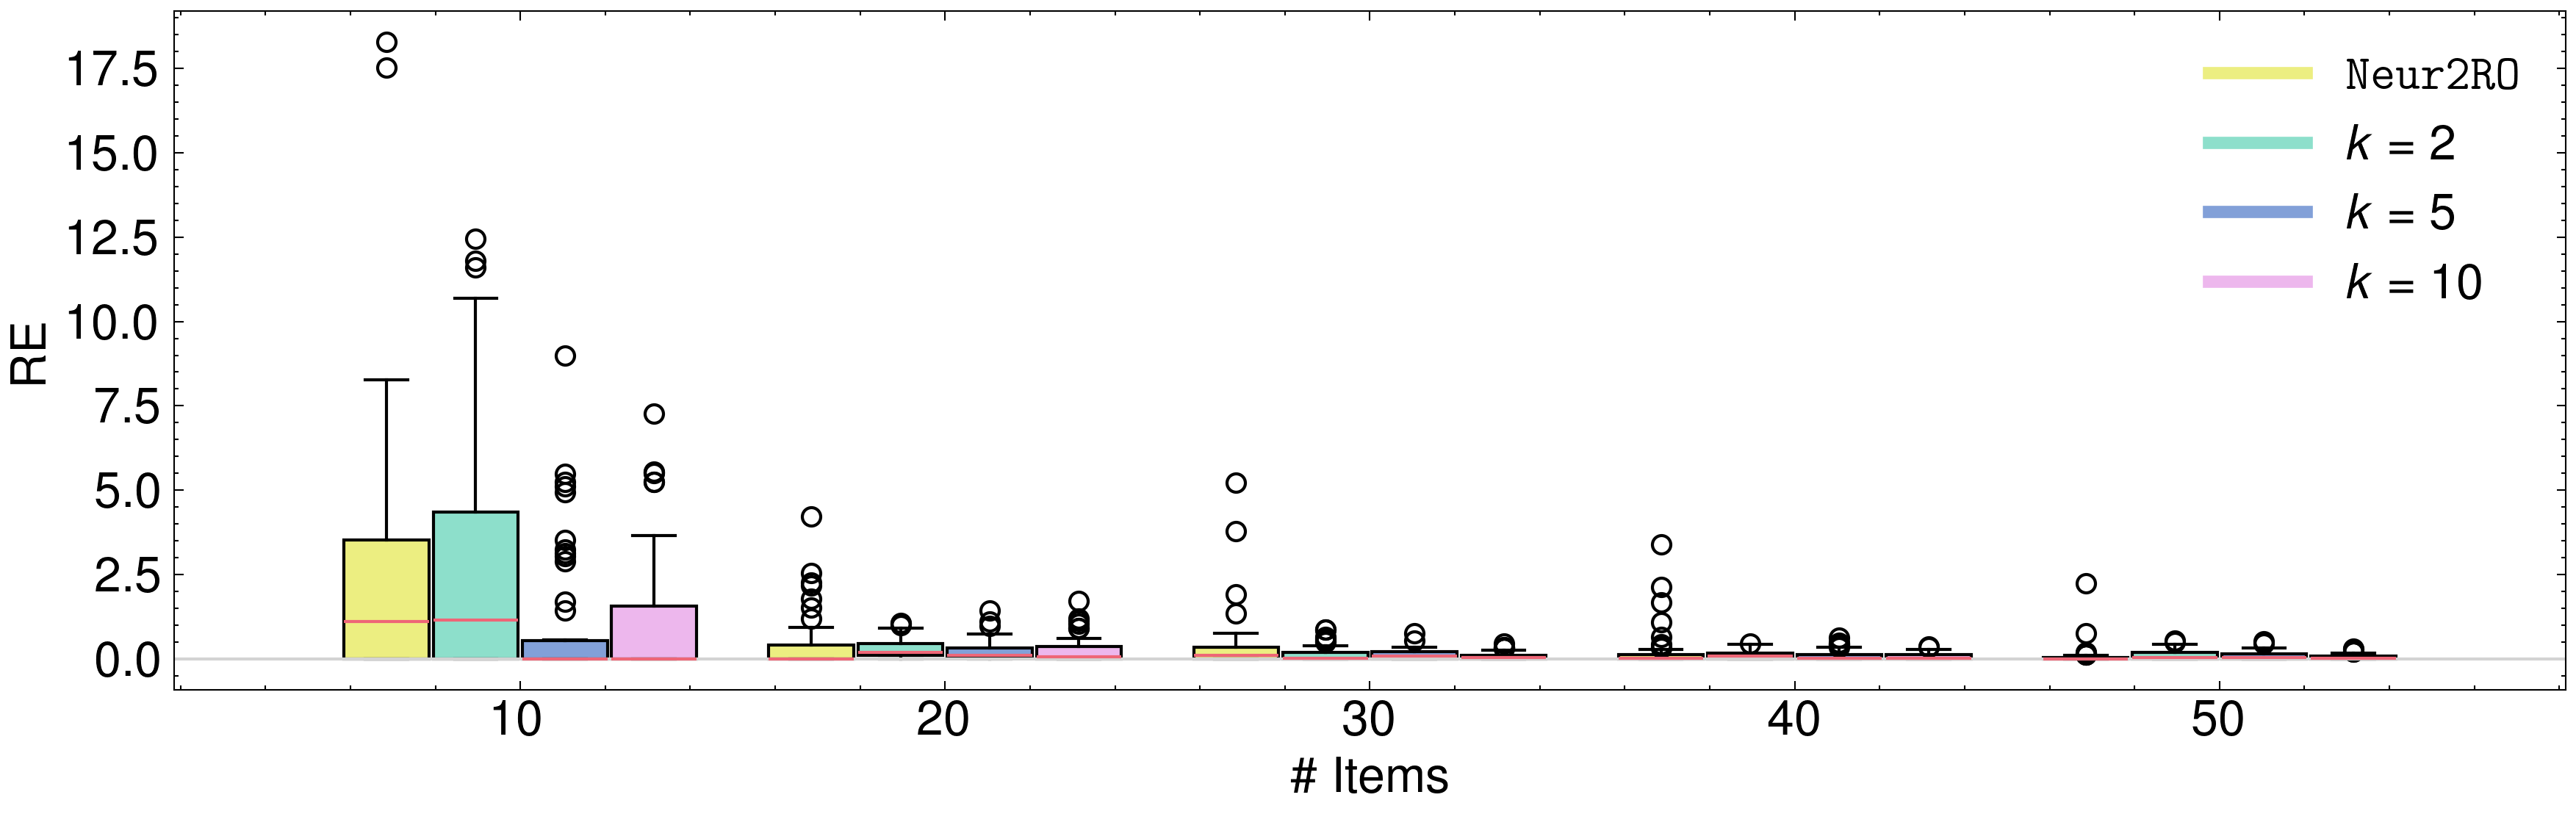

In [26]:
create_boxplot(data_groups, labels, fontsize=16)

In [27]:
split_idx = 3 ## Index to divide tables for readibility

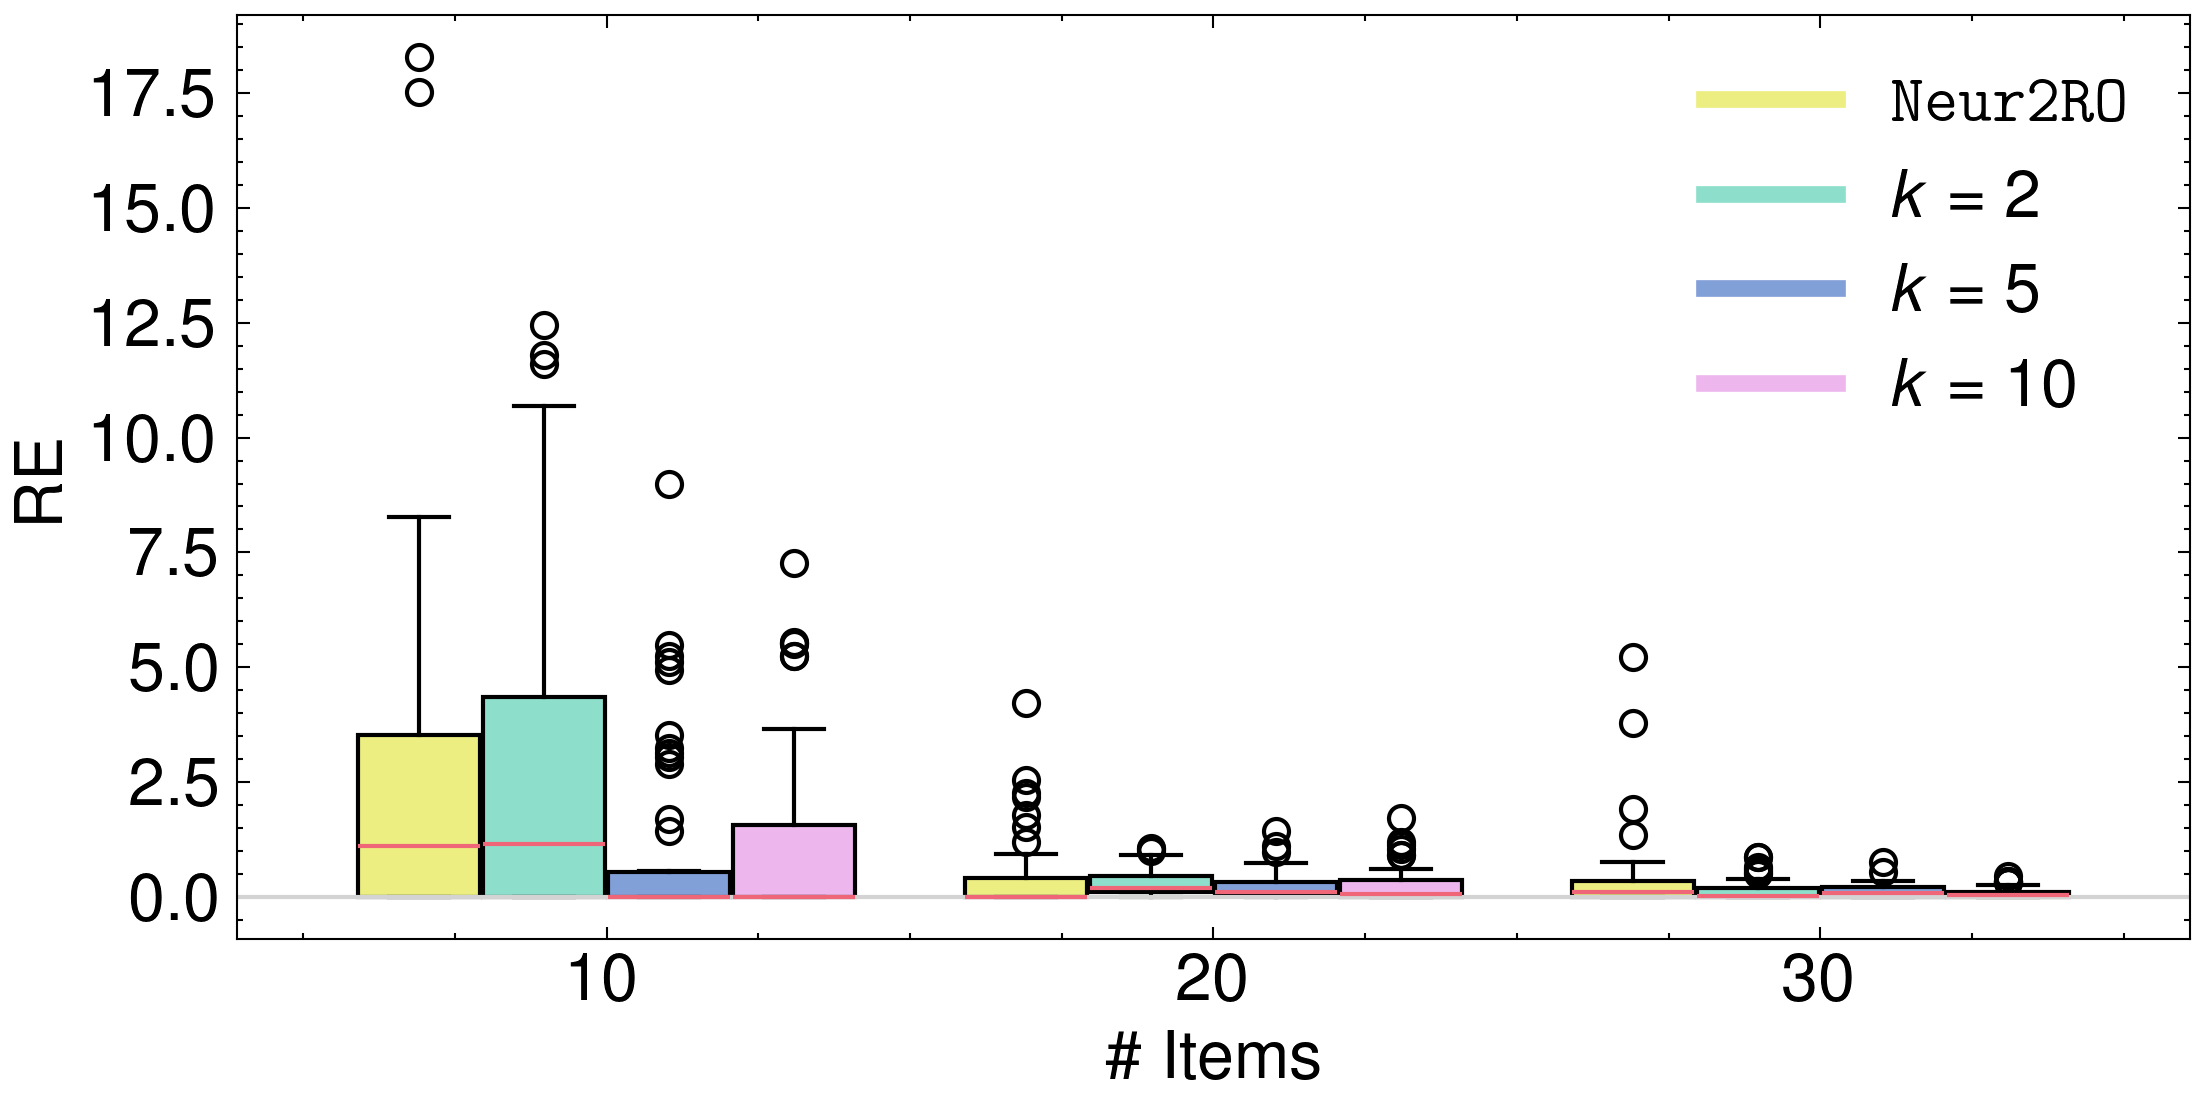

In [28]:
data_groups_1 = copy.deepcopy(data_groups)
data_groups_1[0] = data_groups_1[0][:split_idx]
data_groups_1[1] = data_groups_1[1][:split_idx]
data_groups_1[2] = data_groups_1[2][:split_idx]
data_groups_1[3] = data_groups_1[3][:split_idx]

labels_1 = labels[:split_idx]

create_boxplot(data_groups_1, labels_1, fontsize=16)

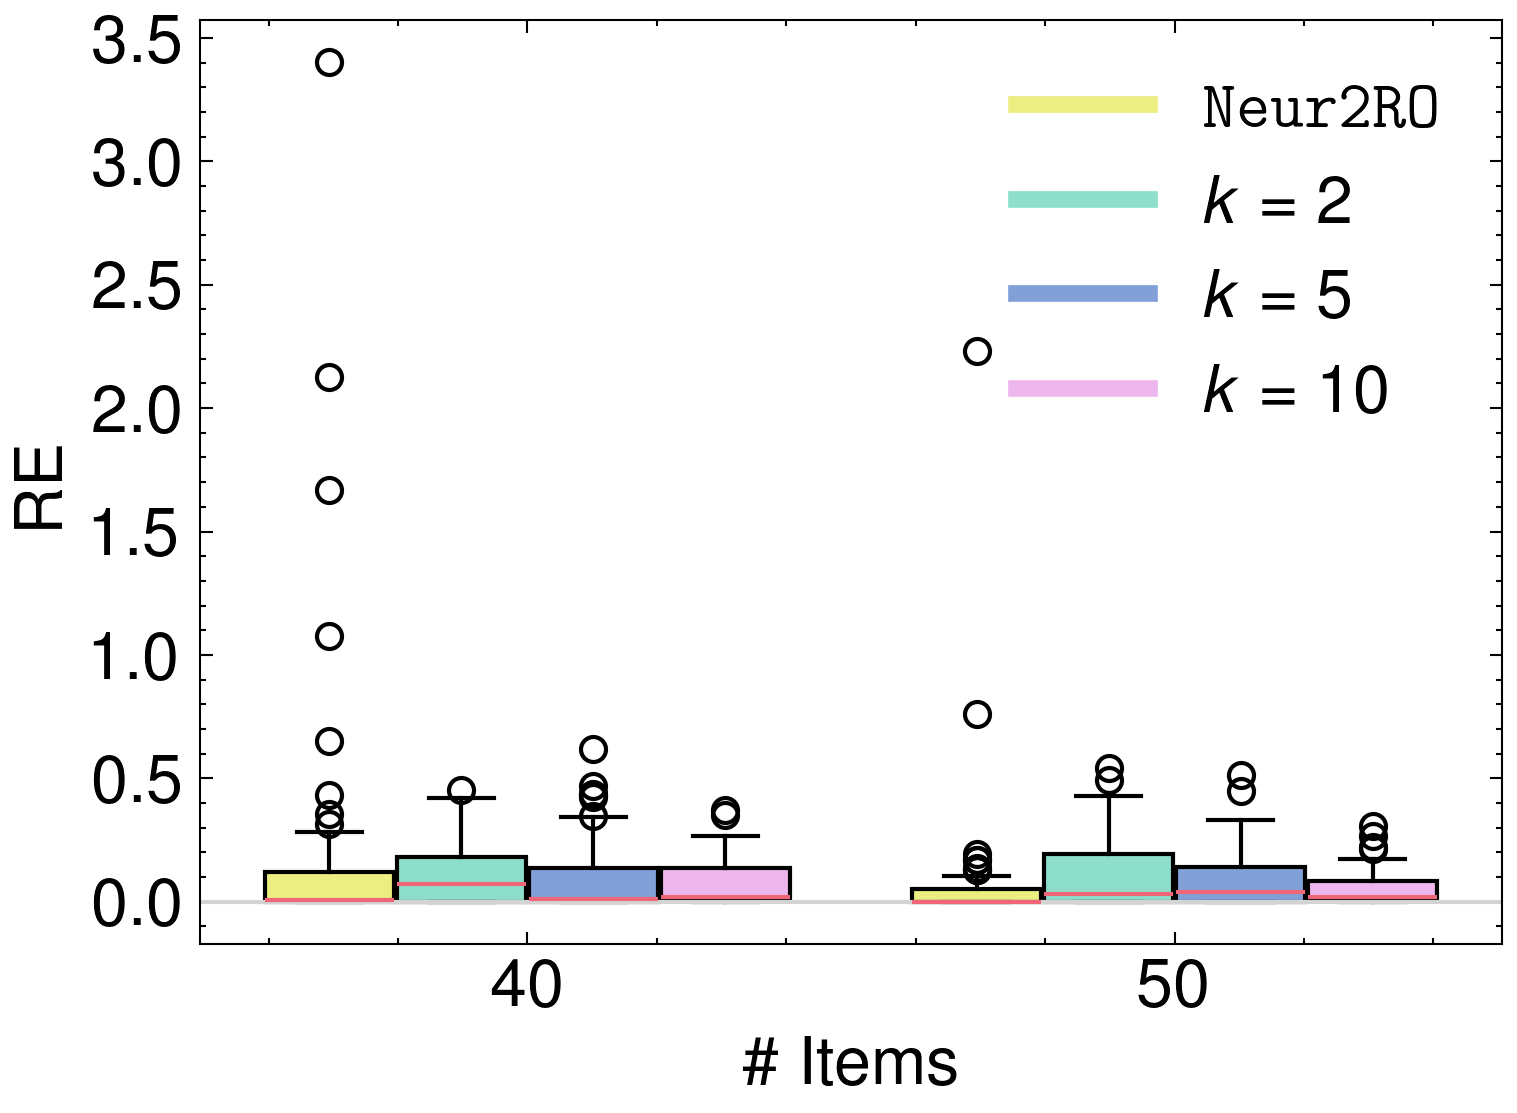

In [29]:
data_groups_2 = copy.deepcopy(data_groups)
data_groups_2[0] = data_groups_2[0][split_idx:]
data_groups_2[1] = data_groups_2[1][split_idx:]
data_groups_2[2] = data_groups_2[2][split_idx:]
data_groups_2[3] = data_groups_2[3][split_idx:]

labels_2 = labels[split_idx:]

create_boxplot(data_groups_2, labels_2, fontsize=16)

# Appendix: Distributional Tables

In [30]:
def get_agg_df_extended(cfg, results, k_vals, res_at_ml_time=False, use_g_mean=False, use_median=False, tol=1e-4):
    """ todo """
    n_items = cfg.n_items
    
    cols = ['mean-re-ml', 'mean-re-2', 'mean-re-5', 'mean-re-10',
            'median-re-ml', 'median-re-2', 'median-re-5', 'median-re-10',
            'q1-re-ml', 'q1-re-2', 'q1-re-5', 'q1-re-10',
            'q3-re-ml', 'q3-re-2', 'q3-re-5', 'q3-re-10',
           ]
    
          
    # initialize dataframe
    df = pd.DataFrame(columns=cols, index=n_items)
    
    # get aggregate results for each number of items
    for n_item in n_items:
        
        # get results at ml time
        n_item_res = get_item_results(results, n_item, k_vals)
        
        # gep to best known
        best_known_sol = get_best_known_solution(n_item_res, k_vals, res_at_ml_time=False)

        # mre for ML
        re_ml = 100 * (best_known_sol - n_item_res['obj_ml']) / best_known_sol
        re_2 = 100 * (best_known_sol - n_item_res[f'obj_2']) / best_known_sol
        re_5  = 100 * (best_known_sol - n_item_res[f'obj_5']) / best_known_sol
        re_10 = 100 * (best_known_sol - n_item_res[f'obj_10']) / best_known_sol
            
        df[f"mean-re-ml"][n_item] = np.nanmean(re_ml)
        df[f"mean-re-2"][n_item]  = np.nanmean(re_2)
        df[f"mean-re-5"][n_item]  = np.nanmean(re_5)
        df[f"mean-re-10"][n_item] = np.nanmean(re_10)
        
        df[f"median-re-ml"][n_item] = np.nanmedian(re_ml)
        df[f"median-re-2"][n_item]  = np.nanmedian(re_2)
        df[f"median-re-5"][n_item]  = np.nanmedian(re_5)
        df[f"median-re-10"][n_item] = np.nanmedian(re_10)
        
        df[f"q1-re-ml"][n_item] = np.percentile(re_ml, 25)
        df[f"q1-re-2"][n_item]  = np.percentile(re_2, 25)
        df[f"q1-re-5"][n_item]  = np.percentile(re_5, 25)
        df[f"q1-re-10"][n_item] = np.percentile(re_10, 25)
        
        df[f"q3-re-ml"][n_item] = np.percentile(re_ml, 75)
        df[f"q3-re-2"][n_item]  = np.percentile(re_2, 75)
        df[f"q3-re-5"][n_item]  = np.percentile(re_5, 75)
        df[f"q3-re-10"][n_item] = np.percentile(re_10, 75)
            
    return df

In [31]:
def latex_main_results_extended(df_):
    """ Generate Latex table for combined results.  """

    df = df_.copy()

    df = df.style.format(thousands=',', precision=3)        
    
    df = df.highlight_min(subset=['mean-re-ml', 'mean-re-2', 'mean-re-5', 'mean-re-10'], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['median-re-ml', 'median-re-2', 'median-re-5', 'median-re-10'], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['q1-re-ml', 'q1-re-2', 'q1-re-5', 'q1-re-10'], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['q3-re-ml', 'q3-re-2', 'q3-re-5', 'q3-re-10'], props='textbf:--rwrap;', axis=1)
    
    end_str = '}\n\\caption{CB: Extended table}\n'
    end_str += '\\label{tab:cb_ext}\n'
    end_str += '\\end{table*}' 
    
    latex_str = df.to_latex(column_format='l|rrrr|rrrr|rrrr|rrrr').replace('_','\_').replace('nan', '-').replace('#', '\#')
    
    latex_str2 = (latex_str.splitlines())
    latex_str2.insert(1, '\\toprule')
    latex_str2.insert(3, '\\midrule')
    latex_str2.insert(-1, '\\bottomrule')
    latex_str2.insert(0, '\\begin{table*}[h]\\centering\\resizebox{0.8\\textwidth}{!}{')
    latex_str2[-1] += end_str

    print("\n".join(latex_str2))
    print()

In [32]:
df = get_agg_df_extended(cfg, results, k_vals)

In [33]:
latex_main_results_extended(df)

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rrrr|rrrr|rrrr|rrrr}
\toprule
 & mean-re-ml & mean-re-2 & mean-re-5 & mean-re-10 & median-re-ml & median-re-2 & median-re-5 & median-re-10 & q1-re-ml & q1-re-2 & q1-re-5 & q1-re-10 & q3-re-ml & q3-re-2 & q3-re-5 & q3-re-10 \\
\midrule
10 & 2.558 & 2.849 & \textbf{1.029} & 1.165 & 1.105 & 1.140 & \textbf{0.000} & \textbf{0.000} & \textbf{0.000} & \textbf{0.000} & \textbf{0.000} & \textbf{0.000} & 3.534 & 4.349 & \textbf{0.547} & 1.557 \\
20 & 0.423 & 0.304 & \textbf{0.232} & 0.266 & \textbf{0.000} & 0.196 & 0.112 & 0.064 & \textbf{0.000} & 0.094 & 0.013 & 0.000 & 0.410 & 0.453 & \textbf{0.320} & 0.362 \\
30 & 0.408 & 0.149 & 0.131 & \textbf{0.084} & 0.109 & \textbf{0.020} & 0.073 & 0.032 & 0.002 & \textbf{0.000} & 0.003 & 0.000 & 0.337 & 0.182 & 0.212 & \textbf{0.110} \\
40 & 0.234 & 0.114 & 0.098 & \textbf{0.073} & \textbf{0.009} & 0.074 & 0.011 & 0.019 & \textbf{0.000} & 0.001 & \textbf{0.000} & 0.002 & \textbf

# Appendix: Data Collection

In [34]:
with open(fp_data, 'rb') as p:
    ml_data = pkl.load(p)

In [35]:
print("Time data collection:", ml_data['total_time'])

Time data collection: 3178.4271247386932


# Appendix: Training

In [36]:
with open(fp_nn_res, 'rb') as p:
    tr_res = pkl.load(p)

In [37]:
print("Time (training):", tr_res["train_time"])

Time (training): 2195.2623586654663


In [38]:
eps = range(1,500, 10)
tr_maes = list(map(lambda x: x['mae'], tr_res['training_stats']['tr_results']))
val_maes = tr_res['training_stats']['val_maes']

In [39]:
colors = ['#82A0D8', 'r',]
fontsize = 16

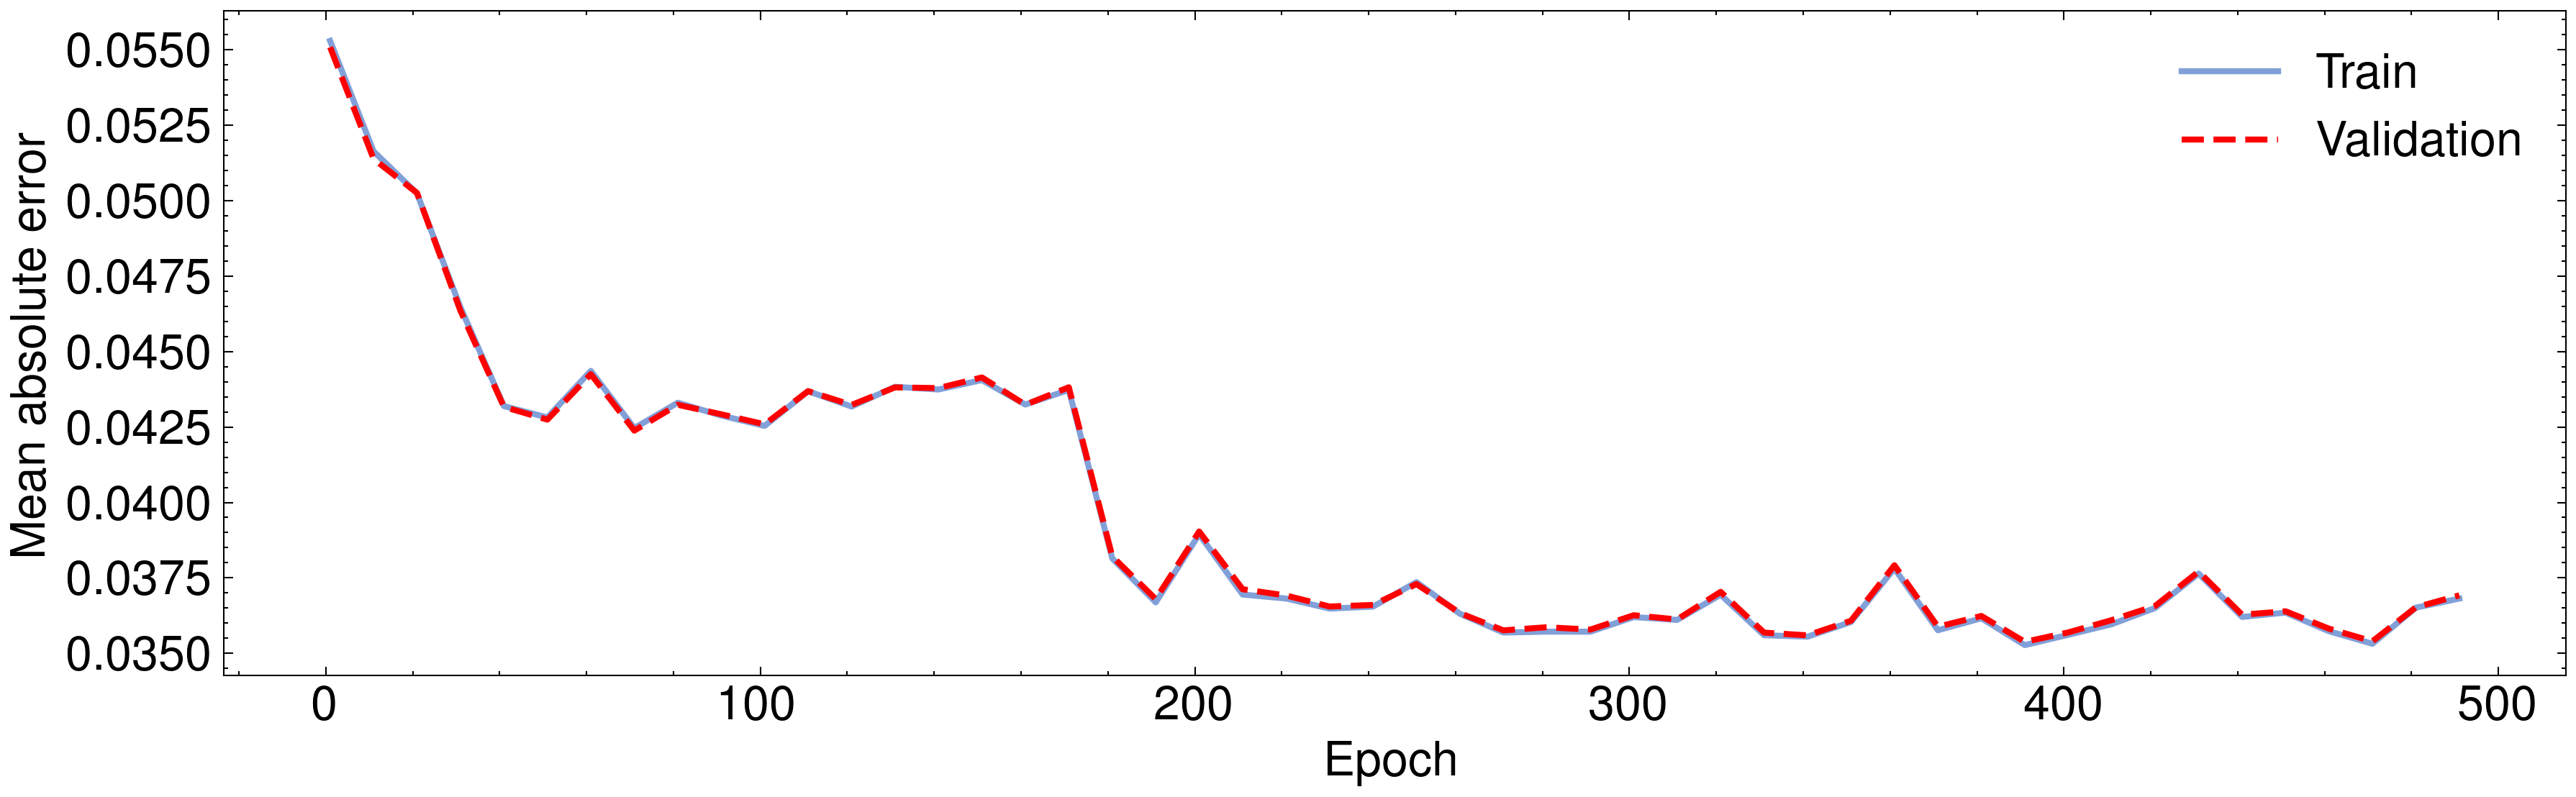

In [40]:
with plt.style.context(['science', 'nature', 'bright']):
    
    fig, ax = plt.subplots(figsize=(14,4), dpi=300)
    
    plt.plot(eps, tr_maes, label = 'Train', color=colors[0], lw=2, alpha=1)
    plt.plot(eps, val_maes, label = 'Validation', color=colors[1], lw=2, alpha=1,  linestyle='dashed')
    
    ax.legend(fontsize=fontsize)
    ax.set_ylabel('Mean absolute error', fontsize=fontsize)
    ax.set_xlabel('Epoch', fontsize=fontsize)

    plt.yticks(fontsize=fontsize)  
    plt.xticks(fontsize=fontsize) 

    plt.show()